# RFM Analysis

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/exam/processed/merged_data_with_ratings.csv')
display(df.head())

,CustomerID,Age,Gender,Location,MembershipLevel,TotalPurchases,TotalSpent,FavoriteCategory,LastPurchaseDate,WebsiteClickRate,TimeSpentOnSite,SocialMediaEngagement,AdClickHistory,GeneratedReview,CustomerSentimentScore,PersonaTag,Churn,llm_sentiment
0,4efed90,Female,Denver,CO,Silver,12,753.6,Clothing,2023-10-20,0.065,15.2,Medium,Clicked,"Great experience, love this store!",0.91,Regular Buyer,0,5
1,d7f26e8,Male,Los Angeles,CA,Gold,28,2155.4,Electronics,2023-10-25,0.092,22.5,High,Sometimes,Very happy with my purchases.,0.95,Loyal,0,4
2,6b4a427,Other,Chicago,IL,Platinum,41,4510.1,Home Goods,2023-09-18,0.115,28.1,High,Clicked,Excellent service and products.,0.98,Loyal,0,5
3,68eec52,Male,Houston,TX,Bronze,2,85.7,Books,2023-08-01,0.041,8.9,Low,Not Clicked,"Had some issues, not fully satisfied.",0.52,Window Shopper,1,2
4,3a2af82,Female,Phoenix,AZ,Silver,18,1220.5,Beauty,2023-10-10,0.078,18.7,Medium,Clicked,Will definitely buy again.,0.88,Engaged,0,4


RFM Customer Segmentation:
            Recency  Frequency  Monetary R_Quartile F_Quartile M_Quartile  \
CustomerID                                                                  
006f135        10.0          1         1          4          2          2   
0078894       399.0          1         1          2          2          2   
010e880       437.0          1         1          2          2          2   
0130f5b       758.0          1         1          1          2          2   
01a733c       231.0          1         1          4          2          2   

           RFM_Score  Segment  
CustomerID                     
006f135          422    Other  
0078894          222    Other  
010e880          222    Other  
0130f5b          122  At Risk  
01a733c          422    Other  


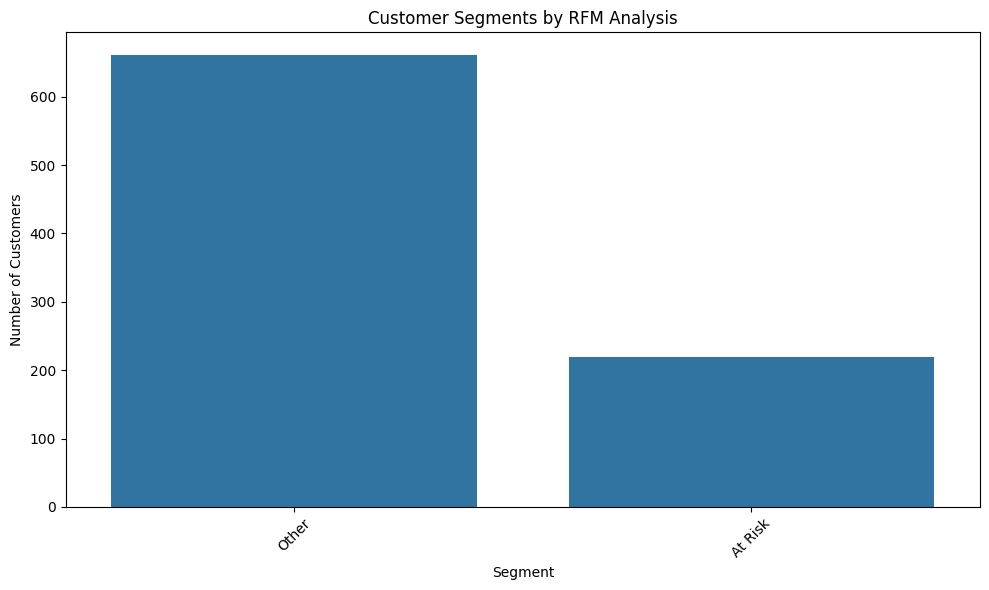

In [11]:
# Perform RFM analysis
def perform_rfm_analysis(df):
    # Use the most recent date in the dataset as the reference date
    # make sure 'LastPurchaseDate' is in datetime format
    df['LastPurchaseDate'] = pd.to_datetime(df['LastPurchaseDate'], errors='coerce')
    max_date = df['LastPurchaseDate'].max()
    
    # Calculate RFM metrics
    rfm = df.groupby('CustomerID').agg({
        'LastPurchaseDate': lambda x: (max_date - x.max()).total_seconds() / (3600*24),  # Recency in days
        'TotalPurchases': 'count',  # Frequency
        'SocialMediaEngagement': lambda x: len(x.unique())  # Monetary (using number of stores as proxy)
    }).rename(columns={
        'LastPurchaseDate': 'Recency',
        'TotalPurchases': 'Frequency',
        'SocialMediaEngagement': 'Monetary'
    })
    
    # Create RFM segments with error handling
    try:
        rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=range(4, 0, -1), duplicates='drop')
    except ValueError:
        # If qcut fails, use simple ranking
        rfm['R_Quartile'] = pd.cut(rfm['Recency'], 4, labels=range(4, 0, -1))
    
    try:
        rfm['F_Quartile'] = pd.qcut(rfm['Frequency'], 4, labels=range(1, 5), duplicates='drop')
    except ValueError:
        rfm['F_Quartile'] = pd.cut(rfm['Frequency'], 4, labels=range(1, 5))
    
    try:
        rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=range(1, 5), duplicates='drop')
    except ValueError:
        rfm['M_Quartile'] = pd.cut(rfm['Monetary'], 4, labels=range(1, 5))
    
    # Combine RFM scores
    rfm['RFM_Score'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str) + rfm['M_Quartile'].astype(str)
    
    # Define customer segments
    segment_map = {
        r'[4][4-5][4-5]': 'Champions',
        r'[3][3-5][3-5]': 'Loyal Customers',
        r'[1-2][4-5][4-5]': 'Potential Loyalists',
        r'[1-2][3][2-3]': 'New Customers',
        r'[1][1-2][1-2]': 'At Risk'
    }
    
    rfm['Segment'] = 'Other'
    for pattern, segment in segment_map.items():
        rfm.loc[rfm['RFM_Score'].str.contains(pattern), 'Segment'] = segment
    
    return rfm

# Perform RFM analysis
rfm_analysis = perform_rfm_analysis(df)
print("RFM Customer Segmentation:")
print(rfm_analysis.head())

# Visualize customer segments
plt.figure(figsize=(10, 6))
segment_counts = rfm_analysis['Segment'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Customer Segments by RFM Analysis')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../images/rfm_segments.png')